# Benchmark Algorithms

This notebook describes an approach for testing how well different tranmission and reception algorithms cope with varying levels of additive white Gaussian noise (AWGN).

We begin with some imports.

In [1]:
from pprint import pprint

import pandas as pd
import plotly.express as px
import torch
from IPython.display import Image

from torchradio import DeviceLogs, Receiver, Transmitter
from torchradio.algorithm import DSSS, Modem
from torchradio.env.null import ControlledSNREnvironment

Begin by defining a selection of algorithms to compare. Here, we use an assortment of different `Modem`-based algorithms.

In [2]:
modem_dict = {
    "BPSK": Modem("psk", 2),
    "QPSK": Modem("psk", 4),
    "PSK64": Modem("psk", 64),
    "QAM16": Modem("qam", 16),
    "DSSS-4-BPSK": DSSS(torch.randint(0, 2, (4,))),
    "DSSS-8-BPSK": DSSS(torch.randint(0, 2, (8,))),
}

test_algorithms = {
    modem_name: {"tx": Transmitter(modem.tx), "rx": Receiver(modem.rx)}
    for modem_name, modem in modem_dict.items()
}

transmitters, receivers = (
    {
        algorithm_name: algorithm[x]
        for algorithm_name, algorithm in test_algorithms.items()
    }
    for x in ["tx", "rx"]
)

Next, we create a special environment called `ControlledSNREnvironment`. This environment supports a single transmitter/receiver pair at a time, and applies AWGN according to same pre-specified signal-to-noise ratio (SNR). `ControlledSNREnvironment` is an unbounded environment that does not take device positions into account.

Let's begin with an SNR of 0. That is, the power of the signal is equal to the power of the background noise.

In [3]:
env = ControlledSNREnvironment(0)

We can place a single QPSK transmitter/receiver inside a `ControlledSNREnvironment` at a time like so.

In [4]:
transmitter_name = "tx-test"
receiver_name = "rx-test"
algorithm = "QPSK"
env.place(
    {transmitter_name: transmitters[algorithm]},
    {receiver_name: receivers[algorithm]},
)
pprint(env.devices)

{'receivers': {'rx-test': Position(x=0, y=0, z=0)},
 'transmitters': {'tx-test': Position(x=0, y=0, z=0)}}


If we attempt to place too many devices, `ControlledSNREnvironment` will raise a `ValueError`.

```python
>>> env.place(
>>>     {transmitter_name: transmitters[algorithm], "tx-test2": transmitters["bpsk"]},
>>>     {receiver_name: receivers[algorithm]}
>>> )
ValueError(...)
```

Let's revert to the previous device placement and run a simulation for 200 timesteps.

In [5]:
env.place(
    {transmitter_name: transmitters[algorithm]},
    {receiver_name: receivers[algorithm]},
)
device_logs = env.simulate(200)

From `device_logs` we can carry out an analysis.

In [6]:
def _analyze(device_logs: DeviceLogs, *, verbose: bool = False) -> dict[str, float]:
    # get transmitter and receiver names
    transmitter_names = list(device_logs.tx.keys())
    receiver_names = list(device_logs.rx.keys())

    # check device_logs only contain a single tx/rx pair
    assert len(transmitter_names) == 1
    assert len(receiver_names) == 1

    transmitter_name = transmitter_names[0]
    receiver_name = receiver_names[0]

    # transmitted and received bits
    original_bits = device_logs.tx[transmitter_name].metadata["bits"]
    recovered_bits = device_logs.rx[receiver_name]["bits"]
    matched_bits = recovered_bits == original_bits
    bit_error_rate = 1 - torch.mean(matched_bits.float()).item()

    # separate received signal and noise
    background_noise = device_logs.rx[receiver_name]["noise"]
    rx_pure_signal = device_logs.rx[receiver_name]["raw"] - background_noise
    snr = (
        10 * torch.log10(torch.var(rx_pure_signal) / torch.var(background_noise)).item()
    )

    # throughput
    n_bits = original_bits.shape[-1]
    signal_length = device_logs.tx[transmitter_name].signal.shape[-1]
    throughput = n_bits / signal_length

    if verbose:
        print(f"Basic Analysis for {transmitter_name} to {receiver_name}:")
        print(f"- Bit Error Rate: {100 * bit_error_rate:.2f}%")
        print(f"- SNR: {snr:.2f}dB")
        print(f"- Throughput: {throughput} bits per sample")

    return {"Bit Error Rate": bit_error_rate, "SNR (dB)": snr, "Throughput": throughput}


analysis = _analyze(device_logs, verbose=True)

Basic Analysis for tx-test to rx-test:
- Bit Error Rate: 14.25%
- SNR: 0.00dB
- Throughput: 2.0 bits per sample


We can carry out the same analysis over many different algorithms and SNRs like so:

In [7]:
results_dict = {"Algorithm": []}
n_timesteps = 5120
for snr in torch.linspace(-15, 5, 40):
    env.set_snr(snr)
    for algorithm_name, devices in test_algorithms.items():
        env.place(
            {f"{algorithm_name}-tx": devices["tx"]},
            {f"{algorithm_name}-rx": devices["rx"]},
        )
        device_logs = env.simulate(n_timesteps)
        result = _analyze(device_logs, verbose=False)

        results_dict["Algorithm"].append(algorithm_name)

        for k, v in result.items():
            if k not in results_dict:
                results_dict[k] = []
            results_dict[k].append(v)

Converting the `results` dictionary into a `pd.DataFrame` yields:

In [8]:
results_df = pd.DataFrame(results_dict)
results_df.head()

,Algorithm,Bit Error Rate,SNR (dB),Throughput
0,BPSK,0.404883,-14.999999,1.00
1,QPSK,0.428320,-15.000000,2.00
2,PSK64,0.478190,-15.000000,6.00
3,QAM16,0.471094,-15.000000,4.00
4,DSSS-4-BPSK,0.340625,-14.999999,0.25


From a `pd.DataFrame` we can easily create figures using tools such as `plotly`.

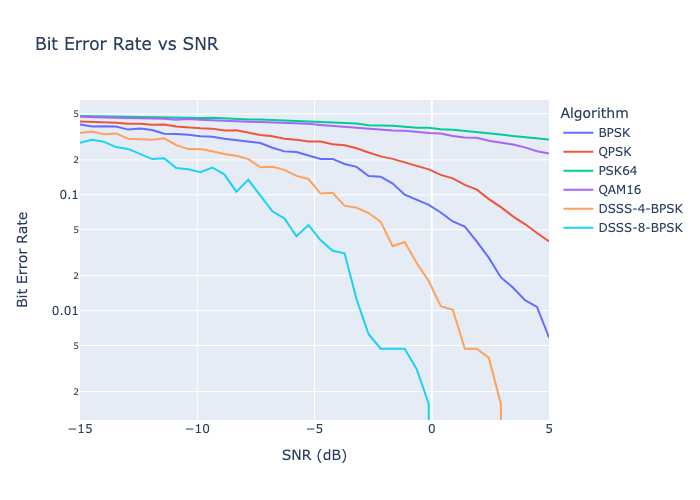

In [9]:
fig = px.line(
    results_df,
    x="SNR (dB)",
    y="Bit Error Rate",
    color="Algorithm",
    title="Bit Error Rate vs SNR",
    log_y=True,
)
Image(fig.to_image(format="png"))

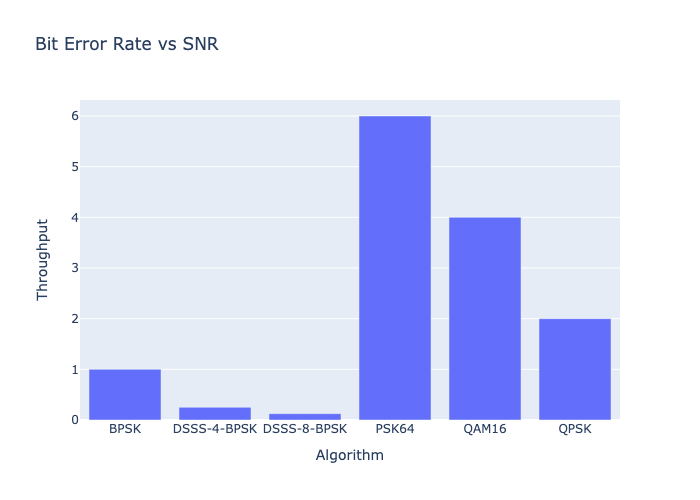

In [10]:
throughput_df = results_df.groupby("Algorithm")["Throughput"].mean().reset_index()
fig = px.bar(
    throughput_df,
    x="Algorithm",
    y="Throughput",
    log_y=False,
    title="Bit Error Rate vs SNR",
)
Image(fig.to_image(format="png"))

We can examine algorithms for performance tradeoffs between bit error rate and throughput at -10dB. Examining such tradeoffs is important when we want to determine whether an AI-discovered algorithm has any edge over state-of-the-art.

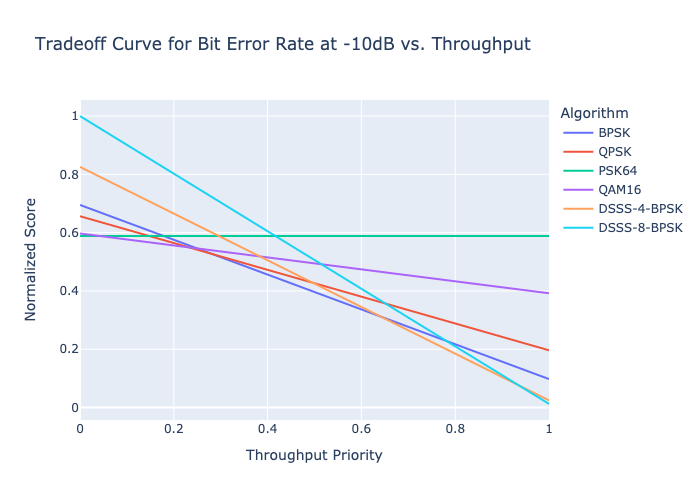

In [11]:
def _normalize_column(df: pd.DataFrame, column_name: str) -> None:
    df[f"Normalized {column_name}"] = df[column_name] / df[column_name].abs().max()


# isolate low SNR results
snr_limit = -14.9
low_snr_results = results_df[results_df["SNR (dB)"] < snr_limit].copy()

# "explode" each row with tradeoff parameter alpha
low_snr_results["alpha"] = [
    torch.linspace(0, 1, 20).numpy().tolist() for _ in range(len(low_snr_results.index))
]
low_snr_results = low_snr_results.explode("alpha").reset_index()

# normalize columns to make scales for tradeoff metrics similar
_normalize_column(low_snr_results, "Throughput")
_normalize_column(low_snr_results, "Bit Error Rate")

# compute scores
low_snr_results["Score"] = low_snr_results.apply(
    lambda x: (1 - x["alpha"]) * (1 / x["Normalized Bit Error Rate"])
    + x["alpha"] * x["Normalized Throughput"],
    axis=1,
)
_normalize_column(low_snr_results, "Score")

fig = px.line(
    low_snr_results,
    x="alpha",
    y="Normalized Score",
    color="Algorithm",
    title="Tradeoff Curve for Bit Error Rate at -10dB vs. Throughput",
    labels={"alpha": "Throughput Priority"},
)
Image(fig.to_image(format="png"))